In [1]:
import cv2
import numpy as np
import os
import random
from sklearn.cluster import KMeans
import time
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

In [5]:
path=r'C:\Users\AZKA REHMAN\Desktop\8th sem\CV\scene_categories'
category_names,train_data,test_data=train_test_split(path)

In [4]:
def train_test_split(path):
    for folder in path:
        names_of_categories = os.listdir(path)
    training_labelled_paths=[]
    testing_labelled_paths=[]
    label=0
    for i in  names_of_categories:
        folder = os.path.join(path,i)
        imgs = os.listdir(folder)
        split=0
        for img in imgs:
            image= os.path.join(folder,img)
            split+=1
            if split<=100:
                training_labelled_paths.append((image,label))
            else: 
                testing_labelled_paths.append((image,label))
        label+=1
    return names_of_categories, training_labelled_paths,testing_labelled_paths
    

In [126]:

img_desc,y=gen_sift_features(train_data)


In [101]:
k=50 #clusters
X,kmeans=bow_features(img_desc,k)

In [203]:
model,standardScalar=SVC_training(X,y)

In [142]:
#testing
st=time.time()
test_desc,t=gen_sift_features(test_data)

In [143]:
#joblib.dump((img_desc,y,X,kmeans,vocabulary,model,standardScalar,test_desc,t), "bovw200clusters.pkl", compress=3)

['bovw200clusters.pkl']

In [102]:
img_desc,y,X,kmeans,vocabulary,model,standardScalar,test_desc,t=joblib.load("bovw50clusters.pkl")

Accuracy= 0.45666666666666667
confusion matrix=
[[ 3  0  0  3  7  1  0  0  0  0  0  1  0  4  1]
 [ 0 19  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  2  2  4  0  0  1  0  0  0  6  2  0  2]
 [ 3  0  1  5  6  0  0  0  0  0  0  3  0  1  1]
 [ 4  0  0  2  9  0  0  0  1  0  0  0  1  2  1]
 [ 0  0  0  0  0 11  0  3  0  6  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  1  1  1  0  0  0]
 [ 1  0  1  0  0  2  0 16  0  0  0  0  0  0  0]
 [ 3  0  0  4  0  0  0  0 12  0  0  0  0  1  0]
 [ 0  0  0  0  1  2  1  2  0 12  0  1  0  0  1]
 [ 0  0  0  0  0  5  0  5  0  7  3  0  0  0  0]
 [ 0  0  3  1  0  0  0  1  1  4  0  7  1  0  2]
 [ 0  1  3  0  2  0  0  0  1  1  0  2  7  3  0]
 [ 5  1  0  2  4  0  0  0  1  0  0  0  0  6  1]
 [ 1  0  2  4  3  0  0  0  0  0  0  2  0  0  8]]


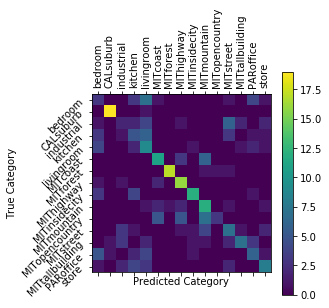

In [103]:
Xtest,tl,tc=model_testing(model,test_desc,t,kmeans,k,standardScalar,category_names)

In [92]:
def gen_sift_features(labeled_img_paths):
    img_descs = []
    for img_path, label in labeled_img_paths:
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create()
        kp, desc = sift.detectAndCompute(gray, None)
        img_descs.append(desc)
        y = np.array(labeled_img_paths)[:,1]
    return img_descs, y

def bow_features(img_desc,k):
    all_train_descriptors = [desc for desc_list in img_desc for desc in desc_list]
    all_train_descriptors = np.array(all_train_descriptors)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(all_train_descriptors)
    vocabulary=kmeans.cluster_centers_
    bag_of_words = [kmeans.predict(raw_words) for raw_words in img_desc]
    img_bow_hist = np.array(
        [np.bincount(clustered_words, minlength=k) for clustered_words in bag_of_words])

    X = img_bow_hist
    print( 'done generating BoW histograms.')
    return X, kmeans

def SVC_training(X,labels):
    standardScalar = StandardScaler().fit(X)
    X = standardScalar.transform(X)
    model = SVC(gamma='auto',kernel='rbf')
    m=model.fit(X,labels)
    return model,standardScalar

def model_testing(model,test_desc,t,kmeans,k,standardScalar,category_names):
    all_test_descriptors = [desc for desc_list in test_desc for desc in desc_list]
    all_test_descriptors = np.array(all_test_descriptors)
    bag_of_words = [kmeans.predict(raw_words) for raw_words in test_desc]
    img_bow_hist = np.array(
        [np.bincount(clustered_words, minlength=k) for clustered_words in bag_of_words])
    X = img_bow_hist
    X = standardScalar.transform(X)
    t = np.array(t).astype(int)
    predictions = model.predict(X)
    predictions=np.array(predictions).astype(int)
    true_class =  [category_names[i] for i in t]
# Perform the predictions and report predicted class names. 
    predictions =  [category_names[i] for i in predictions]
    accuracy = accuracy_score(true_class, predictions)
    print("Accuracy=",accuracy)
    
    conf_mat= confusion_matrix(true_class,predictions,labels=category_names)
    print("confusion matrix=")
    print(conf_mat)
    plt.matshow(conf_mat)
    plt.ylabel('True Category')
    plt.xlabel('Predicted Category')
    plt.colorbar()
    plt.xticks(np.arange(len(category_names)),category_names,rotation=90)
    plt.yticks(np.arange(len(category_names)),category_names,rotation=45)
    plt.show()